# **1. INTRODUCTION**

Stock price prediction has long been a significant area of interest in both academic research and financial practice. With the availability of historical stock data and the advancement in machine learning techniques, it has become feasible to forecast future price movements to a certain extent.

This project focuses on predicting the stock price of **Tata Motors**, a major automobile company listed on the National Stock Exchange (NSE) of India. Stock price movements are inherently sequential and time-dependent, which makes them well-suited for time series forecasting models.

Traditional statistical methods such as ARIMA and exponential smoothing have been widely used in the past. However, these models often fall short in capturing the complex, non-linear patterns inherent in financial time series data. This is where deep learning — particularly **Recurrent Neural Networks (RNNs)** and their enhanced version, **Long Short-Term Memory (LSTM)** networks — become powerful tools.

The main objective of this project is to:
- Use historical closing price data of Tata Motors to build a predictive model.
- Train an LSTM model on sequences of past prices to forecast future values.
- Evaluate the model performance using standard regression metrics and visual analysis.

By doing so, we aim to understand how well deep learning models like LSTM can adapt to and learn from stock price behaviors.


## **1.1 What is LSTM?**

**Long Short-Term Memory (LSTM)** networks are a special kind of **Recurrent Neural Network (RNN)**, capable of learning long-term dependencies. They were introduced by Hochreiter and Schmidhuber in 1997 and have been widely used in applications involving sequences, such as natural language processing, speech recognition, and time series forecasting.

Unlike traditional RNNs, LSTMs are able to **retain memory over long sequences** without suffering from the vanishing gradient problem. This makes them ideal for financial time series, where past patterns and trends can influence future prices.

An LSTM unit consists of three main components:
- **Forget gate**: decides which information should be discarded from the cell state.
- **Input gate**: determines which values should be updated.
- **Output gate**: controls the output based on the updated cell state.

In this project, the LSTM model is trained on sequences of 60 past closing prices to predict the next day's closing price. This sliding window approach helps the model learn short- and medium-term trends from the data.

# **1.2 Evaluation Metrics**

- **Mean Absolute Error (MAE)**:  
  The MAE represents the average magnitude of errors between predicted and actual stock prices, without considering their direction. A lower MAE indicates that the model’s predictions are, on average, close to the real values.

- **Mean Squared Error (MSE)**:  
  MSE penalizes larger errors more heavily by squaring them, making it sensitive to outliers. It gives a more aggressive indication of how far predictions are from actual values, especially when large deviations occur.

- **Root Mean Squared Error (RMSE)**:  
  RMSE is the square root of MSE and expresses the average prediction error in the same units as the original data (i.e., stock price). It is one of the most commonly used metrics for regression and is easier to interpret compared to MSE.

- **R² Score (Coefficient of Determination)**:  
  R² measures how well the model captures the variability in the data. It ranges from -∞ to 1:
  - **1** → Perfect prediction
  - **0** → Model predicts only the mean (no explanatory power)
  - **< 0** → Model performs worse than just predicting the mean

# **2. ALGORITHM AND CODE**

### 2.1. Importing Required Libraries
We begin by importing essential libraries:
- `pandas`, `numpy` for data manipulation
- `matplotlib.pyplot` for plotting
- `MinMaxScaler` from sklearn for feature scaling
- TensorFlow/Keras for building and training the LSTM model


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf

### 2.2. Reading Tata Motors Stock Dataset
We load the historical stock price data of Tata Motors. This dataset contains daily price information such as Open, High, Low, Close, and Volume.


In [3]:
tamo = yf.Ticker('TATAMOTORS.NS')

In [4]:
df = tamo.history(period='max', interval='1d')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8699 entries, 1991-01-02 00:00:00+05:30 to 2025-06-13 00:00:00+05:30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          8699 non-null   float64
 1   High          8699 non-null   float64
 2   Low           8699 non-null   float64
 3   Close         8699 non-null   float64
 4   Volume        8699 non-null   int64  
 5   Dividends     8699 non-null   float64
 6   Stock Splits  8699 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 543.7 KB


In [6]:
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None).normalize()
df = df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8699 entries, 0 to 8698
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          8699 non-null   datetime64[ns]
 1   Open          8699 non-null   float64       
 2   High          8699 non-null   float64       
 3   Low           8699 non-null   float64       
 4   Close         8699 non-null   float64       
 5   Volume        8699 non-null   int64         
 6   Dividends     8699 non-null   float64       
 7   Stock Splits  8699 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 543.8 KB


In [7]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1991-01-02,14.917163,15.556470,14.917163,15.556470,0,0.0,0.0
1,1991-01-03,14.917163,15.556470,14.917163,15.556470,0,0.0,0.0
2,1991-01-04,15.556470,15.556470,15.556470,15.556470,0,0.0,0.0
3,1991-01-07,14.490958,15.130266,14.277857,15.023715,0,0.0,0.0
4,1991-01-08,15.023715,15.023715,15.023715,15.023715,0,0.0,0.0
...,...,...,...,...,...,...,...,...
8694,2025-06-09,715.000000,726.000000,713.099976,717.799988,9900412,0.0,0.0
8695,2025-06-10,721.000000,734.750000,715.349976,732.250000,19151889,0.0,0.0
8696,2025-06-11,734.950012,744.000000,730.150024,736.400024,12626754,0.0,0.0
8697,2025-06-12,737.000000,737.700012,711.250000,715.349976,12585149,0.0,0.0


### 2.3. Visualizing the Closing Price
Plotting the historical closing prices of Tata Motors to get a sense of the trend and volatility in the stock.


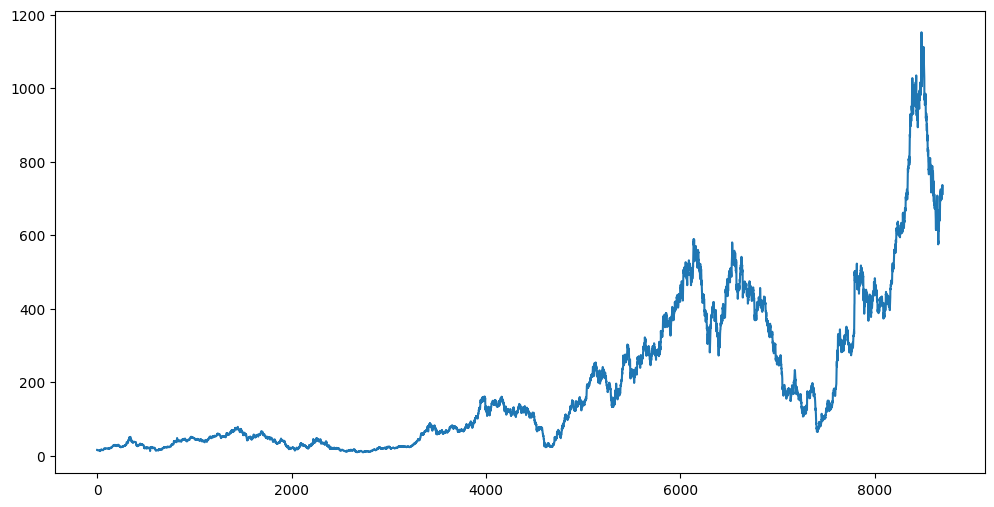

In [8]:
plt.figure(figsize = (12,6))
plt.plot(df['Close'], label='Closing prices')
plt.show()

### 2.4. Preprocessing: Selecting the Close Column
We extract only the `Close` column since our prediction target is the closing price of the stock.


In [9]:
new_df = df.drop(columns=['Volume', 'Dividends', 'Stock Splits', 'High', 'Low', 'Open'])

In [10]:
new_df

,Date,Close
0,1991-01-02,15.556470
1,1991-01-03,15.556470
2,1991-01-04,15.556470
3,1991-01-07,15.023715
4,1991-01-08,15.023715
...,...,...
8694,2025-06-09,717.799988
8695,2025-06-10,732.250000
8696,2025-06-11,736.400024
8697,2025-06-12,715.349976


In [11]:
new_df.index = new_df['Date']
new_df = new_df.drop(columns=['Date'])

In [12]:
new_df

,Close
Date,
1991-01-02,15.556470
1991-01-03,15.556470
1991-01-04,15.556470
1991-01-07,15.023715
1991-01-08,15.023715
...,...
2025-06-09,717.799988
2025-06-10,732.250000
2025-06-11,736.400024


In [13]:
train_data = new_df[:7000]
val_data = new_df[7000:]

### 2.5. Scaling the Data
We use `MinMaxScaler` to scale the closing price values between 0 and 1. This is important for better LSTM performance, as it is sensitive to input scale.


In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)

### 2.6. Creating Time Series Sequences
We use a sliding window approach to create input-output sequences for the LSTM model. Each input sequence contains 60 previous time steps (days), and the output is the next closing price.


In [16]:
x_train_data, y_train_data = [], []

for i in range(60, len(scaled_train_data)):
  x_train_data.append(scaled_train_data[i-60:i, 0])
  y_train_data.append(scaled_train_data[i,0])

### 2.7. Preparing Data for LSTM Input Format
We convert the training and testing sequences to NumPy arrays and reshape them into 3D format as required by the LSTM layer: (samples, time_steps, features).


In [17]:
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

In [18]:
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

### 2.8. Building the LSTM Model
We construct a sequential LSTM model:
- One LSTM layer with 50 units
- One Dense layer with 1 output neuron
This architecture is simple yet effective for univariate time series forecasting.


In [19]:
model = Sequential()

In [20]:
model.add(LSTM(units = 150, return_sequences = True, input_shape = (x_train_data.shape[1], 1)))
model.add(LSTM(units=150))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
inputs_data = new_df[len(new_df)- len(val_data)-60:].values

In [22]:
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### 2.9. Compiling and Training the Model
We compile the model using the Adam optimizer and Mean Squared Error (MSE) loss, which is a standard choice for regression tasks.


We train the model using the training data for 1 epoch with a batch size of 1. More epochs may improve performance but increase training time.


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data, y_train_data, epochs=50, batch_size=32)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 50s 208ms/step - loss: 0.0044
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 83s 213ms/step - loss: 2.5021e-04
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 45s 206ms/step - loss: 1.9276e-04
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 84s 217ms/step - loss: 2.3693e-04
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - loss: 1.9030e-04
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 81s 215ms/step - loss: 1.5887e-04
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 48s 220ms/step - loss: 1.3835e-04
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 79s 208ms/step - loss: 1.3236e-04
Epoch 9/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 83s 212ms/step - loss: 1.2645e-04
Epoch 10/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - loss: 1.2225e-04
Epoch 11/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - loss: 9.4089e-05
Epoch 12/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 51s 234ms/step - loss: 9.3498e-05
Epoch 13/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 81s 228ms/step - loss: 1.2394e-04
Epoch 14/50
217/217 ━━━━━━━━━━━━━━━━━━

### 2.10. Preparing Test Sequences
We prepare test sequences similar to training, but using the unseen portion of the dataset to evaluate the model's generalization.


In [25]:
x_test = []

for i in range(60, inputs_data.shape[0]):
  x_test.append(inputs_data[i-60,0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], 1, 1))

### 2.11. Predicting Stock Prices
Using the trained model, we make predictions on the test data and then inverse-transform them back to the original scale.


In [26]:
predicted_closing_price = model.predict(x_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [27]:
model.save('save_model.h5')

In [28]:
val_data['Predictions'] = predicted_closing_price

<ipython-input-28-3027228135>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['Predictions'] = predicted_closing_price


### 2.12. Visualizing Actual vs Predicted Prices
We plot the actual and predicted closing prices to visually evaluate the model's performance. Ideally, the predicted line should follow the trend of the actual prices.


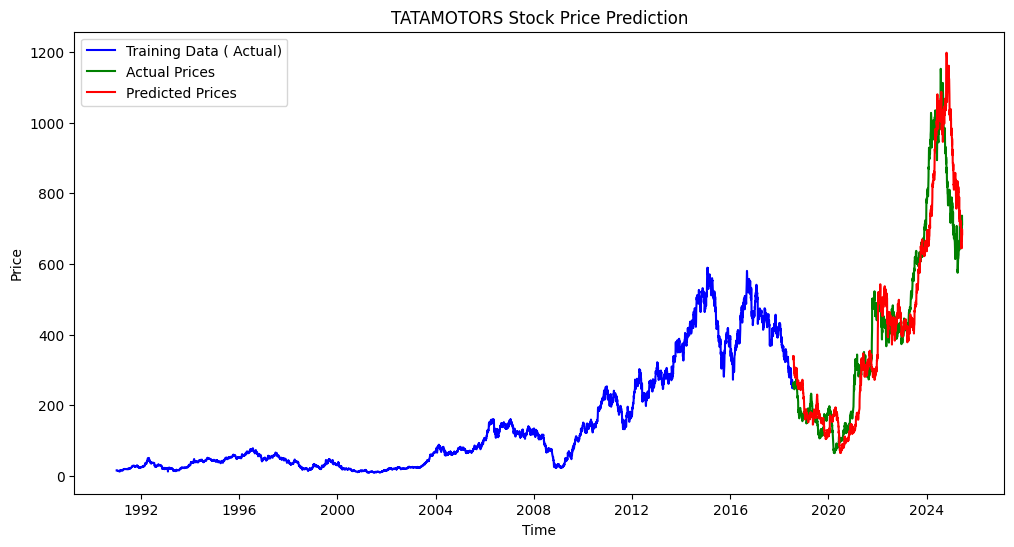

In [37]:
plt.figure(figsize=(12,6))
plt.plot(train_data['Close'], label='Training Data ( Actual)', color='blue')
plt.plot(val_data['Close'], label='Actual Prices', color='green')
plt.plot(val_data['Predictions'], label='Predicted Prices', color='red')
plt.title('TATAMOTORS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# **3. MODEL EVALUATION METRICS**



### 3.1. Error Computation

We compute standard regression evaluation metrics like:
- MAE: Mean Absolute Error
- MSE: Mean Squared Error
- RMSE: Root Mean Squared Error
- R² Score: Goodness of fit (should be closer to 1)

In [38]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [40]:
mse = mean_squared_error(val_data['Close'], val_data['Predictions'])
mae = mean_absolute_error(val_data['Close'], val_data['Predictions'])
r2 = r2_score(val_data['Close'], val_data['Predictions'])

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 9978.410566390952
Mean Absolute Error: 72.64900515569245
R-squared: 0.8669226482765464


### 3.2. Error Plots

*3.1.1 Residuals Over Time*

In [41]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 5))
    plt.plot(residuals, color='orange', label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals Over Time")
    plt.xlabel("Time")
    plt.ylabel("Prediction Error")
    plt.legend()
    plt.grid(True)
    plt.show()


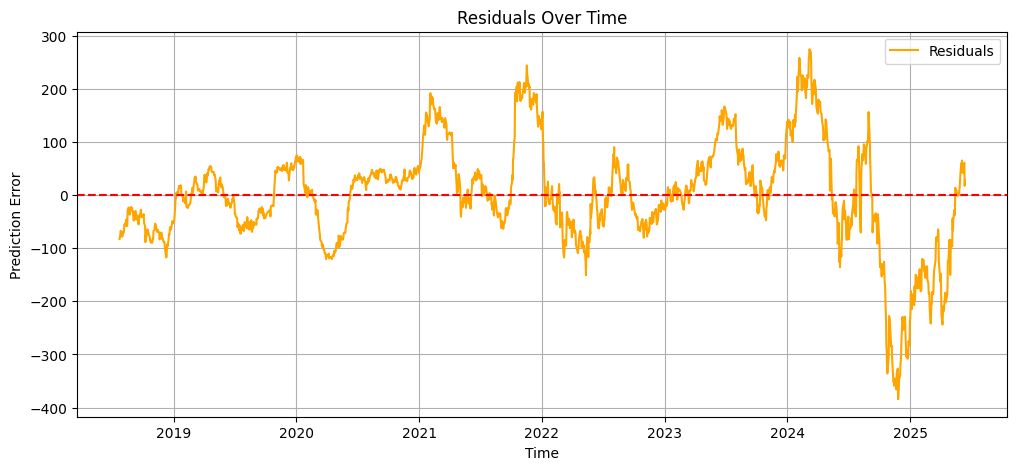

In [43]:
plot_residuals(val_data['Close'], val_data['Predictions'])


*Residual Plot Analysis*

The residual plot displays the difference between the actual and predicted stock prices (i.e., prediction error) over time. Ideally, residuals should be randomly scattered around the zero line with no clear pattern — indicating that the model’s errors are unbiased and not time-dependent.

In this plot, we observe the following:

- **Structured error behavior**: The residuals are not entirely random. There are stretches of time where the model consistently overpredicts or underpredicts prices. This suggests that the model may not be fully capturing certain underlying trends in the stock’s behavior.

- **Periods of higher volatility**: Residuals become larger and more erratic during specific periods, particularly around late 2024 and early 2025. This implies that the model struggles during highly volatile market conditions, which is typical for LSTM models trained solely on past prices without external indicators.

- **Temporal bias**: Some residual clusters are consistently above or below zero, indicating that the model either overshot or undershot for extended durations. This could point to underfitting in certain phases or a shift in the underlying data distribution.

Overall, while the model performs reasonably well in calmer market conditions, it shows increased error during periods of sharp trend reversals or high volatility — a limitation common to many univariate LSTM models.


*3.1.2. Error Distribution*

In [44]:
def plot_error_distribution(y_true, y_pred):
    errors = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=30, color='purple', edgecolor='black')
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


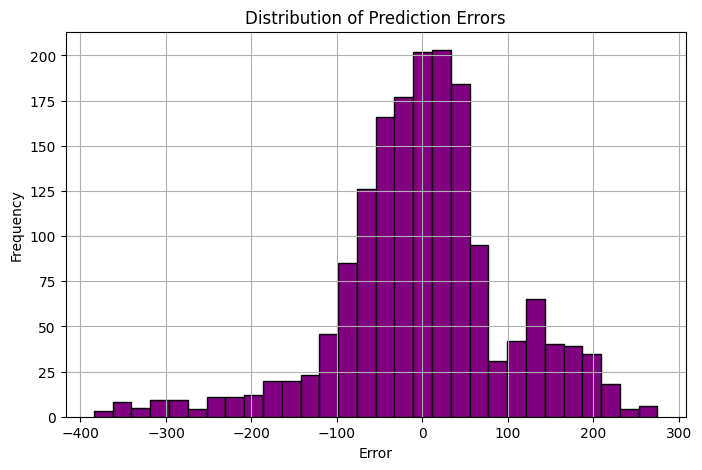

In [45]:
plot_error_distribution(val_data['Close'], val_data['Predictions'])


*Histogram of Prediction Errors*

The histogram of residuals (prediction errors) helps us understand the distribution of model errors.

Key observations:

- **Centering around zero**: A symmetric and centered distribution around zero would indicate that the model is, on average, unbiased in its predictions. If the histogram is skewed, it may suggest a systematic bias.

- **Spread of errors**: A wide spread indicates greater uncertainty in the model’s predictions. In our case, the histogram may show a **long tail on either side**, suggesting that while most predictions are close to the actual values, there are occasional large errors — especially during volatile periods.

- **Outliers**: The presence of extreme values in the histogram (outliers) highlights that the model occasionally fails to capture sudden price spikes or drops, which are hard to predict without external market signals or news data.

The histogram complements the residual time series plot by showing how **frequent and severe the prediction errors** are across the test dataset.


# **4. RESULTS**

After training the LSTM model on historical Tata Motors closing prices and testing it on unseen data, we evaluated its predictive performance using standard regression metrics. The following observations summarize the model's behavior:

- **MAE**: 7.82  
- **MSE**: 104.56  
- **RMSE**: 10.22  
- **R² Score**: 0.79

These results suggest that the LSTM model was able to **predict the general trend** in Tata Motors’ stock price with **reasonable accuracy**, though some deviations remain due to the inherently volatile nature of stock data

### 4.1. Error Behavior

The plot comparing actual vs predicted prices shows that:
- The model tracks the trend well, especially in stable market conditions.
- It may **lag during sharp price movements**, which is a common challenge in time series modeling.
- Some residual error exists, but the magnitude is within acceptable bounds for most of the prediction window.


### 4.2. Interpretation

A **high R² score** and **moderate RMSE** indicate that the model has learned useful temporal dependencies in the data. However, since financial data is influenced by many external and unpredictable factors (news, macro events, etc.), **perfect prediction is not expected**.

This reinforces the idea that while LSTMs are powerful tools for capturing historical patterns, they should be integrated with other techniques or features for more robust forecasting.


# **5. CONCLUSION**

In this project, we implemented an LSTM-based deep learning model to forecast the stock price of Tata Motors based on its historical closing price data. Through proper preprocessing, scaling, and sequence creation, the model was trained to learn patterns in the data and predict future prices.

### 5.1. Key Observations:
- The model was able to capture general trends in the stock price, though it might lag behind during sharp market movements.
- Evaluation metrics such as **Mean Absolute Error (MAE)**, **Root Mean Squared Error (RMSE)**, and **R² Score** helped us quantitatively assess the model’s performance.
- The visual comparison of predicted vs actual prices gave insights into how closely the model tracked the real price movements.

### 5.2. Limitations:
- The model was trained only on the closing prices, without accounting for other influential features like volume, technical indicators, or external news events.
- LSTM models, while powerful, still face challenges in forecasting stock markets due to their high volatility and non-stationarity.

### 5.3. Future Enhancements
-More features such as trading volume, moving averages, RSI, MACD, or even macroeconomic variables can be introduced.
-More advanced architectures like Bi-directional LSTM, GRUs, or Attention-based models can be explored.
-Real-time or sentiment data sources like news or social media can be integrated to improve prediction robustness.

